In [1]:
library(survminer)
library(ggfortify)
library(tidyverse)
library(ggplot2)
library(survival)
library(cowplot)
library(patchwork)

Loading required package: ggplot2

Loading required package: ggpubr

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.2.1
✔ purrr     1.0.4     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘survival’


The following object is masked from ‘package:survminer’:

    myeloma



Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp


The following object is masked from ‘package:ggpubr’:

    get_legend



Attaching package: ‘patchwork’


The following object is masked from ‘package:cowplot’:

    align_plots




In [2]:
calculate_gene_signature_scores <- function(exp, ano, signatures, method = "colSums") {
  if (method == "ssgsea" && !requireNamespace("GSVA", quietly = TRUE)) {
    stop("Package 'GSVA' is required for ssgsea method. Install it using install.packages('GSVA').")
  }
  
  for (fate in names(signatures)) {
    genes_in_set <- signatures[[fate]]
    valid_genes <- rownames(exp) %in% genes_in_set
    
    if (sum(valid_genes) == 1) {
      warning(paste("Only one gene found for signature:", fate))
      single_gene <- rownames(exp)[valid_genes]
      ano[[paste0("gene_set:", fate)]] <- exp[single_gene, ]
    } else if (sum(valid_genes) > 1) {
      if (method == "colSums") {
        ano[[paste0("gene_set:", fate)]] <- colSums(exp[valid_genes, , drop = FALSE])
      } else if (method == "ssgsea") {
        gsva_output <- GSVA::gsva(exp, signatures, method = "ssgsea", verbose = FALSE)
        signature_scores <- t(gsva_output)
        for (mv in colnames(signature_scores)) {
          ano[[paste0("gene_set:", mv)]] <- signature_scores[, mv]
        }
      } else {
        stop("Invalid method. Choose either 'colSums' or 'ssgsea'.")
      }
    } else {
      warning(paste("No matching genes found for signature:", fate))
      ano[[paste0("gene_set:", fate)]] <- rep(NA, ncol(exp))
    }
  }
  
  return(ano)
}


In [3]:
surv_ad <- function(gs, exp, ano, stages = NULL, mycn = NULL, high_risk = NULL, out = NULL) {
  # Default title
  title <- "All samples"
  
  if (!is.null(mycn) && !is.null(high_risk)) {
    title <- paste("High risk =", high_risk, "and MYCN =", ifelse(mycn == 1, "amplified", "non-amplified"))
  } else if (!is.null(mycn)) {
    title <- paste("MYCN =", ifelse(mycn == 1, "amplified", "non-amplified"))
  } else if (!is.null(high_risk)) {
    title <- paste("High risk =", high_risk)
  }
  
  if (!is.null(stages)) {
    title <- paste(title, "| Stage(s):", paste(stages, collapse=", "))
  }
  
  if (startsWith(gs, "gene_set:")) {
    res <- ano
    res$exp <- ano[[gs]]
  } else {
    if (!(gs %in% rownames(exp)))
      return()
    
    res <- data.frame("exp" = as.numeric(exp[gs, ]), ano)
  }
  
  res <- res[!is.na(res$exp), ]
  
  # Filter by stages
  if (!is.null(stages)) {
    res <- res[res$inss %in% stages, ]
  }
  
  # Filter by MYCN status
  if (!is.null(mycn)) {
    res <- res[!is.na(res$mycn.status) & res$mycn.status == mycn, ]
  }
  
  # Filter by high-risk
  if (!is.null(high_risk)) {
    res <- res[!is.na(res$high.risk) & res$high.risk == high_risk, ]
  }
  
  cut1 <- quantile(res$exp, 0.75) #0.75
  cut2 <- quantile(res$exp, 0.25) #.25
  
  res1 <- res[res$exp >= cut1, ]
  res2 <- res[res$exp <= cut2, ]
  
  res1$group <- "High freq (>75%)"
  res2$group <- "Low freq (<25%)"
  
  res <- rbind(res1, res2)
  
  # Convert time to years
  res$time <- res$time / 365
  
  fit <- survfit(Surv(time, vital_status) ~ group, data = res)
  pv <- surv_pvalue(fit, data = res)
  
  p <- ggsurvplot(
    fit, data = res, pval = TRUE,
    risk.table = TRUE,
    risk.table.col = "strata",
    palette = c("#9d1403", "#3172b8"),  # Custom colors
    title = title,
    legend.title = "",
    legend.labs = c("High freq (>75%)", "Low freq (<25%)"),
    xlab = "Time from diagnosis (years)",
    ylab = "Probability of OS",
    risk.table.y.text = FALSE,
    risk.table.title = "Numbers at risk",
    pval.method = FALSE,
    pval.coord = c(0, 0.2)  # Adjust position of p-value
  )

  if (is.null(out)) {
    return(p$plot)
  } else {
      return(p)
  }
  
}


In [4]:
# pre-processing of SEQC dataset:

dat=readRDS('/home/irina/survival_cancers_data/neuroblastoma_bulk_survival/GSE49711.dat.rds')

exp=dat$dat
ano=dat$ano

ano$time=as.numeric(ano$OS)
ano$vital_status=ano$OS.event
ano$inss=ano$inss.stage


In [5]:
table(ano$inss, useNA = "ifany")


  1   2   3   4  4S 
121  78  63 183  53 

In [6]:
signatures = list()
signatures$mesenchymal_early=c(
  "MYC", "RUVBL1", "DIXDC1", "RAI14", "ID1", "TWIST1", "LRIG3", "PSMG1", "MYO1B", "IFRD2",
  "RHOJ", "DDX31", "KCTD1", "DUSP6", "COLEC12", "SPRY4", "ANXA7", "NCL", "ITGA8", "SH3BP5",
  "HSPA9", "COL9A1", "RBP1", "PHLDA1", "DESI1", "WDR74", "IMPDH1", "ACTN1", "CDH11", "CCND3",
  "FHL3", "MOGAT2", "DLC1", "ZNHIT6", "MEST", "EEF1D", "IL11RA", "SLC7A5", "PGM2", "ATIC",
  "EIF4EBP1", "WDR75", "EMG1", "GUSB", "MEIS2", "RIN2", "SRM", "S1PR2", "MRPL12", "RUVBL2",
  "TRAF4", "NME1", "PEG3", "CDC42EP5", "PRDX6", "SLC1A5", "FZD2", "NHP2", "SNAI1", "HOPX",
  "RRP8", "CSN3", "PTGIS", "SULF2", "CCN1", "CCL15", "CCL23"
)

signatures$ribosomal_assembly = c('WDR74', 'WDR75', 'NCL', 'NHP2', 'EEF1D', 'RUVBL1', 'RUVBL2', 'DDX31', 'EMG1', 
                                         'RRP8', 'MRPL12', "ZNHIT6")

signatures$ribosomal_structural_proteins = c('RPL22', 'RPL11', 'RPS8', 'RPL5', 'RPS27', 'RPS24', 'RPS13',
 'RPS25', 'RPLP2', 'RPL27A', 'RPS3', 'RPL6', 'RPLP0', 'RPS26', 'RPL41', 'RPL21', 'RPL10L', 'RPS29',
 'RPL36AL', 'RPS27L', 'RPL4', 'RPS17', 'RPLP1', 'RPL3L', 'RPS2', 'RPS15A', 'RPL13', 'RPL26', 'RPL23', 'RPL23A',
 'RPL19', 'RPL27', 'RPL38', 'RPL17', 'RPS16', 'RPL18', 'RPS15', 'RPL36', 'RPS28', 'RPL18A', 'RPS19', 'RPL13A', 'RPS11',
 'RPS9', 'RPL28', 'RPS5', 'RPS7', 'RPS27A', 'RPL31', 'RPL37A', 'RPS21', 'RPL3', 'RPL32', 'RPL29', 'RPL24',
 'RPL22L1', 'RPL39L', 'RPL15', 'RPSA', 'RPL14', 'RPL35A', 'RPL9', 'RPL34', 'RPS3A', 'RPL37', 'RPS23', 'RPS14',
 'RPL26L1', 'RPS10', 'RPS18', 'RPL10A', 'RPL7L1', 'RPS12', 'RPS20', 'RPL7', 'RPL30', 'RPL8', 'RPS6', 'RPL35',
 'RPL12', 'RPL7A', 'RPS4X', 'RPL39', 'RPL36A', 'RPL10', 'RPS4Y1', 'RPS4Y2')

signatures$mesenchymal_late= c(
  "FSTL1", "LRRC58", "REEP5", "VCAM1", "STAMBPL1", "WNT5A", "NKD2", "FARP1", "SSBP3", "CDK6",
  "FLI1", "SERPINF1", "CYTH3", "S1PR3", "FLRT2", "SPIN2A", "COL3A1", "RHOD", "SLC25A4", "TMEM200B",
  "TCF7L1", "PREX2", "RAB3IL1", "NET1", "FRMD6", "VEGFC", "FBLN5", "SEMA5A", "LIN28B", "SIX1",
  "PPFIBP2", "SMPDL3B", "IGFBP4", "PRICKLE1", "NOLC1", "LUM", "VASN", "PCDH18", "TAF4B", "SLC38A4",
  "C15orf39", "PDGFRA", "MTHFD1", "TRIL", "HDAC7", "HAPLN1", "ITM2C", "AMOT", "LRP1", "CPED1",
  "LIMA1", "ALX1", "FAM43A", "MFAP4", "NID1", "ITGB5", "RARG", "MMP2", "CSRP2", "XPO5",
  "CITED1", "ADORA2B", "PDGFRB", "CDC14C", "CDC14B", "EML3", "BMPR1B", "COL4A1", "CD248", "SNAI2",
  "RARB", "FOXC1", "SDC1", "METTL13", "DHRS3", "COL23A1", "PRRX1", "SERTAD4", "EVA1B", "PUS7",
  "SHC1", "PRRX2", "PDLIM4", "PWP2", "MRPL34", "PLVAP", "MRPS34", "DDR2", "PACSIN2", "DUSP12",
  "MRC2", "CD63", "TRAF3IP2", "ITGA9", "ARG1", "CNN2", "RAB32", "CRYM", "UBL4B", "TPM4",
  "A2M", "BGN", "EEF2K", "MTHFD2", "POLR2E", "PITPNC1", "ALX3", "FLNC", "SIX2", "ATAD3A",
  "HMCES", "OBSL1", "DUSP7", "AK2", "SLC25A22", "CLMP", "S100A6", "PLCB1", "NOL9", "LAMP5",
  "TNS1", "MFAP2", "COL26A1", "PDE4A", "EMILIN1", "PPAN", "TNFAIP6", "PCOLCE", "AIMP2", "TMEM119",
  "DACT3", "ALX4", "TBX2", "DDX56", "ST6GALNAC4", "FPGS", "SH2D3C", "DCHS1", "EBF3", "TBX3", "SPRED2"
)

signatures$s_phase=c('MCM5','PCNA','TYMS','FEN1','MCM7','MCM4','RRM1','UNG','GINS2','MCM6','CDCA7','DTL','PRIM1',
           'UHRF1','CENPU','HELLS','RFC2','POLR1B','NASP','RAD51AP1','GMNN','WDR76','SLBP','CCNE2','UBR7',
           'POLD3','MSH2','ATAD2','RAD51','RRM2','CDC45','CDC6','EXO1','TIPIN','DSCC1','BLM','CASP8AP2',
           'USP1','CLSPN','POLA1','CHAF1B','MRPL36','E2F8')
signatures$g2m_phase=c('HMGB2','CDK1','NUSAP1','UBE2C','BIRC5','TPX2','TOP2A','NDC80','CKS2','NUF2','CKS1B',
             'MKI67','TMPO','CENPF','TACC3','PIMREG','SMC4','CCNB2','CKAP2L','CKAP2','AURKB','BUB1',
             'KIF11','ANP32E','TUBB4B','GTSE1','KIF20B','HJURP','CDCA3','JPT1','CDC20','TTK','CDC25C',
             'KIF2C','RANGAP1','NCAPD2','DLGAP5','CDCA2','CDCA8','ECT2','KIF23','HMMR','AURKA','PSRC1',
             'ANLN','LBR','CKAP5','CENPE','CTCF','NEK2','G2E3','GAS2L3','CBX5','CENPA')


In [7]:
### gene signature score as colSums (total of expression)

In [8]:
ano = calculate_gene_signature_scores(exp, ano, signatures, method = "colSums")

fit=NULL
p0 = NULL

plots <- list()
dataset_title <- "Survival Analysis - colSums - noMYCN, stages = 3,4 Patients"  

for (fate in names(signatures)) {
    print(fate)
    p <- surv_ad(paste0('gene_set:', fate), exp, ano, stages = c(3,4), mycn = 0, high_risk = NULL)
    
    if (!is.null(p)) {
        plots[[fate]] <- p + ggtitle(fate)  # Add individual title
    }
}

if (length(plots) > 0) {
    combined_plot <- wrap_plots(plots, ncol = 4) +  # Set to 4 columns per row
                     plot_annotation(title = dataset_title)

    ggsave("figures/fig_survival/colSums.survival.noMYCN.stages3-4_combined.pdf", 
           combined_plot, width = 14.4, height = ceiling(length(plots) / 4) * 4)
}


[1] "mesenchymal_early"
[1] "ribosomal_assembly"
[1] "ribosomal_structural_proteins"
[1] "mesenchymal_late"
[1] "s_phase"
[1] "g2m_phase"


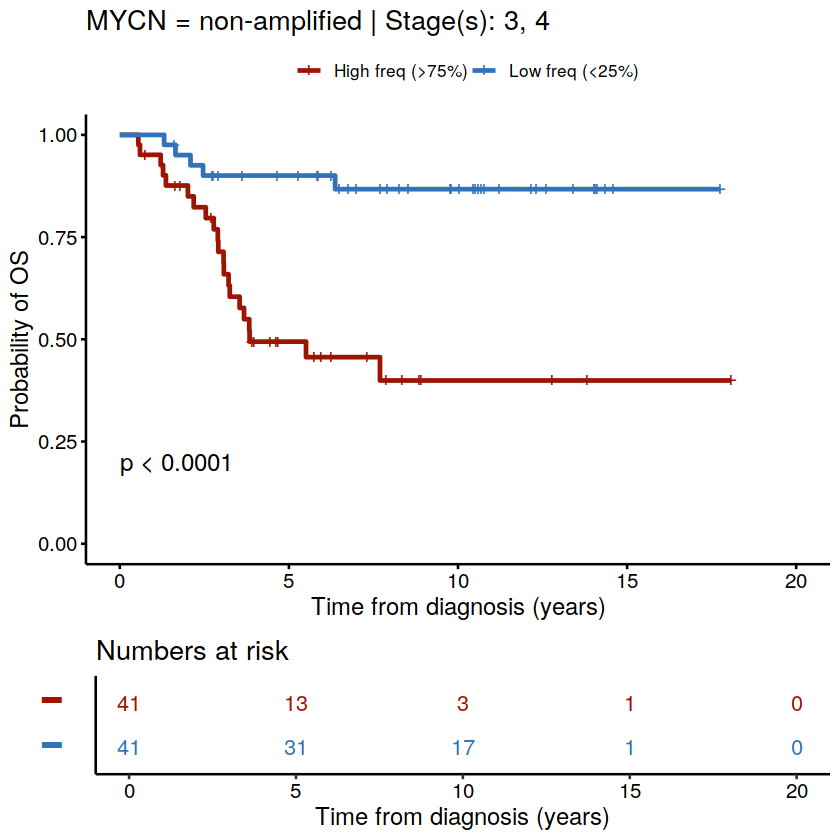

In [9]:
fate = "ribosomal_assembly"
p <- surv_ad(paste0('gene_set:', fate), exp, ano, stages = c(3,4), mycn = 0, high_risk = NULL, out = "full")
print(p)

In [10]:
## SSGSEA_SCORES

In [ ]:
ano = calculate_gene_signature_scores(exp, ano, signatures, method = "ssgsea")


Warning message in .filterFeatures(expr, method):
“113 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“113 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“113 genes with constant expression values throuhgout the samples.”
Warning message in .filterFeatures(expr, method):
“113 genes with constant expression values throuhgout the samples.”


In [ ]:
fate = "ribosomal_assembly"
p <- surv_ad(paste0('gene_set:', fate), exp, ano, stages = c(3,4), mycn = 0, high_risk = NULL, out = "full")
print(p)

In [ ]:
plots <- list()
dataset_title <- "Survival Analysis - MYCN, stages 3, 4 Patients"  # Adjust this title accordingly

for (fate in names(signatures)) {
    print(fate)
    p <- surv_ad(paste0('gene_set:', fate), exp, ano, stages = NULL, mycn = 0, high_risk = NULL)
    
    if (!is.null(p)) {
        plots[[fate]] <- p + ggtitle(fate)  # Add individual title
    }
}

if (length(plots) > 0) {
    combined_plot <- wrap_plots(plots, ncol = 4) +  # Set to 4 columns per row
                     plot_annotation(title = dataset_title)

    ggsave("figures/fig_survival/ssgsea_score.ssGSEA.survival.MYCN.stages_3-4_combined.pdf", 
           combined_plot, width = 14.4, height = ceiling(length(plots) / 4) * 4)

}


In [ ]:
sessionInfo()